# Dashboard

For a sample portfolio, display different metrics and graphics for different risk measurements. Add more graphics and information over time, as the available data in the database grows.

## Portofolio

For a starting point, select 5 ETFs from the iShares Core Series. Adjust later on when developing risk measurements.

## Graphics

Provide information on the portfolio itself as well as each of its components. Identify risks over time and at each point in time. 

* Portoflio composition and exepected holdings as per ETF descrition
* Changes in prices over time
* Risk metrics: VaR, etc.
* Diversification
    * Exposure by Country
    * Exposure by Industry
* Macroeconomics
    * Exposure by GDP / GDP Growth, etc.

In [96]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Time transformation
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Custom modules
import Tools

# Hidden configurations
from mySecrets import AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, AWS_BUCKET


In [2]:
# Connect to AWS S3 storage
s3 = Tools.S3()
s3.connect(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

Connected.


In [26]:
# Get mapping data

# ETF Info - ISIN + Name + Description
etf_info = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/etf_info.tsv")

# ETF Info - ISIN to Symbol for Prices
etf_isin_symbol = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/etf_isin_symbol.tsv")

# Equity Info - ISIN + Name + Country + Industry
equity_info = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/equity_info.tsv")

# Country - Region 
map_iso3 = s3.readFile(BUCKET_NAME=AWS_BUCKET, key="config/mapping/map_iso3.tsv")


## Portfolio

Define the sample portfolio. For starters, select some ETF products from the iShares core series. Later on, provide an optimized portfolio depending on defined risk metrics:

* Maximum / Minimum exposure to certain regions / countries / industries
* Restrictions to price correlations

In [124]:
# Portfolio selection
portfolio = [

['IE00B4L5Y983', .2],	# iShares Core MSCI World UCITS ETF

['IE0031442068', .2],	# iShares Core S&P 500 UCITS ETF USD (Dist)

['IE00BKM4GZ66', .2],	# iShares Core MSCI EM IMI UCITS ETF USD (Acc)

['IE00B1YZSC51', .2],	# iShares Core MSCI Europe UCITS ETF EUR (Dist)	

['IE00B4L5YX21', .2]	# iShares Core MSCI Japan IMI UCITS ETF USD (Acc)

]

df_pf = pd.DataFrame(portfolio, columns=['Security_ISIN', 'Weight'])

# Add more information
df_pf = df_pf.join(etf_info.set_index('Security_ISIN'), on=['Security_ISIN'])

df_pf.head()


,Security_ISIN,Weight,Security_Name,Security_Class,Fund_Company,Domicile,Type,Acc_Dist,Base_CCY
0,IE00B4L5Y983,0.2,iShares Core MSCI World UCITS ETF,ETF,iShares,Irland,Aktien,Acc,USD
1,IE0031442068,0.2,iShares Core S&P 500 UCITS ETF USD (Dist),ETF,iShares,Irland,Aktien,Dist,USD
2,IE00BKM4GZ66,0.2,iShares Core MSCI EM IMI UCITS ETF USD (Acc),ETF,iShares,Irland,Aktien,Acc,USD
3,IE00B1YZSC51,0.2,iShares Core MSCI Europe UCITS ETF EUR (Dist),ETF,iShares,Irland,Aktien,Dist,EUR
4,IE00B4L5YX21,0.2,iShares Core MSCI Japan IMI UCITS ETF USD (Acc),ETF,iShares,Irland,Aktien,Acc,USD


## Get Data

* Prices
* FX
* Holdings


## TODO: create getData class
store all necessary mapping tables in self on __init__
Then, create methods for each type of data: prices, fx, holdings

* getData.mapping() -> Gets all mapping tables
* getData.prices(date, isin_list)
* getData.fx(date, ccy_list)
* getData.distributions(date, isin_list)

### Prices

In [29]:
# Get symbols for each security
df_prices = df_pf.join(etf_isin_symbol.set_index('Security_ISIN'), on='Security_ISIN')
df_prices = df_prices[['Security_ISIN', 'Weight', 'Sym_YahooFin']].rename(columns={'Sym_YahooFin':'Symbol'})
df_prices

,Security_ISIN,Weight,Symbol
0,IE00B4L5Y983,0.2,EUNL.DE
1,IE0031442068,0.2,IUSA.DE
2,IE00BKM4GZ66,0.2,IS3N.DE
3,IE00B1YZSC51,0.2,IQQY.DE
4,IE00B4L5YX21,0.2,EUNN.DE


In [13]:
# Collect all price information for the portfolio

date_prices = "2022_04_15"

file_list = ["{dir}/{date}/{file}.tsv".format(**{'dir': 'data/price_raw', 'date': date_prices, 'file': sym}) for sym in df_prices.Symbol]

prices = pd.DataFrame(columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for key in file_list:

    data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

    # Subset columns
    cols = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
    data = data[[i for i in cols if i in data.columns]]

    # Append 
    prices = prices.append(data)

# Store in data format readable by both Python and R
prices = prices.reset_index().drop(['index'], axis = 1)

prices.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,EUNL.DE,2014-01-02,28.650000,28.750000,28.559999,28.559999,8395.0
1,EUNL.DE,2014-01-03,28.620001,28.730000,28.620001,28.639999,57173.0
2,EUNL.DE,2014-01-06,28.690001,28.709999,28.480000,28.480000,2883.0
3,EUNL.DE,2014-01-07,28.620001,28.790001,28.620001,28.730000,17665.0
4,EUNL.DE,2014-01-08,28.770000,28.780001,28.730000,28.770000,32029.0


### FX

In [40]:
# Collect all FX data
date_fx = "2022_04_25"

file_list = ["{dir}/{date}/{file}.tsv".format(**{'dir': 'data/fx_raw', 'date': date_fx, 'file': ccy+"EUR=X"}) for ccy in df_pf.Base_CCY.unique()]

fx = pd.DataFrame(columns = ['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

for key in file_list:

    try:
        data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

        # Subset columns
        cols = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
        data = data[[i for i in cols if i in data.columns]]

        # Append 
        fx = fx.append(data)
    except:
        continue

# Store in data format readable by both Python and R
fx = fx.reset_index().drop(['index'], axis = 1)

fx.head()

,Symbol,Date,Open,High,Low,Close,Volume
0,USDEUR=X,2013-12-31,0.72423,0.726681,0.72398,0.72411,0.0
1,USDEUR=X,2014-01-01,0.72754,0.727590,0.72574,0.72754,0.0
2,USDEUR=X,2014-01-02,0.72643,0.733530,0.72597,0.72639,0.0
3,USDEUR=X,2014-01-03,0.73173,0.735202,0.73137,0.73171,0.0
4,USDEUR=X,2014-01-06,0.73552,0.736768,0.73281,0.73551,0.0


### Distributions

In [108]:
# Get distributions and calculate distributions over last year

# Download all distribution data
date_distributions = "2022_03_24"

file_list = ["{dir}/{date}/{file}.tsv".format(**{'dir': 'data/distribution_clean', 'date': date_distributions, 'file': isin}) for isin in df_pf.Security_ISIN]

df_dist = pd.DataFrame(columns = ['Security_ISIN'])

for key in file_list:

    # There is only files for distributing ETF-products
    try:
        data = s3.readFile(AWS_BUCKET, key, sep="\t")  

        # Rename columns
        data = data.rename(columns={
            'ExTag': 'Dist_Date_Ex',
            'Fälligkeitsdatum': 'Dist_Date_Payment',
            'Stichtag': 'Dist_Date_Record',
            'ISIN': 'Security_ISIN',
            'Dist': 'Dist_Amount'
        })

        df_dist = df_dist.append(data)
    
    except:
        continue

df_dist

,Security_ISIN,Dist_Amount,Dist_Date_Ex,Dist_Date_Record,Dist_Date_Payment
0,IE0031442068,0.1293,2022-03-17,2022-03-18,2022-03-30
1,IE0031442068,0.1243,2021-12-16,2021-12-17,2021-12-31
2,IE0031442068,0.1233,2021-09-16,2021-09-17,2021-09-29
3,IE0031442068,0.1222,2021-06-17,2021-06-18,2021-06-30
4,IE0031442068,0.1209,2021-03-11,2021-03-12,2021-03-24
...,...,...,...,...,...
54,IE00B1YZSC51,0.0723,2008-10-29,2008-10-31,2008-11-26
55,IE00B1YZSC51,0.3171,2008-07-30,2008-08-01,2008-08-27
56,IE00B1YZSC51,0.1330,2008-04-30,2008-05-02,2008-05-28
57,IE00B1YZSC51,0.0507,2008-01-30,2008-02-01,2008-02-27


## Portfolio 

Calculate portfolio properties and prepare for markdown export

In [125]:
# Calculate number of shares that could be bought at a specific date

cash = 100000 # Asume 100.000 € in cash that can be invested

# Add available cash for each position
df_pf['Cash'] = df_pf['Weight'] * cash

# Add price symbol + ccy
df_pf = df_pf.join(etf_isin_symbol.set_index('Security_ISIN'), on='Security_ISIN')

df_pf = df_pf.rename(columns={'Sym_YahooFin':'Symbol'})

# Add CCY symbol
df_pf['Sym_CCY'] = df_pf['Base_CCY'] + "EUR=X"

df_pf['Date'] = '2022-04-14'

# Add price information
df_pf = df_pf.join(prices[['Symbol', 'Date', 'Close']].rename(columns={'Close': 'Price'}).set_index(['Symbol', 'Date']), on=['Symbol', 'Date'])

# Add fx information
df_pf = df_pf.join(fx[['Symbol', 'Date', 'Close']].rename(columns={'Close': 'FX', 'Symbol': 'Sym_CCY'}).set_index(['Sym_CCY', 'Date']), on=['Sym_CCY', 'Date'])

# Add EUREUR = 1
df_pf.loc[df_pf.Base_CCY == "EUR", 'FX'] = 1

# # Buy PF Holdings

# 1] Estimate transaction costs for trading at Tradegate
# Consorsbank: min(max(9.95, (4.95 + Volume * 0.25%)), 69)
df_pf = df_pf.assign(Transaction_Cost_Est = lambda x: np.minimum(np.maximum(9.95, 4.95 + (x.Cash * 0.0025)), 69))

# 2] Buy shares from Cash - Estimated Transaction Costs
df_pf = df_pf.assign(N = lambda x: np.floor((x.Cash - x.Transaction_Cost_Est) / (x.Price * x.FX)))

# 3] Calculate actual transaction costs
df_pf = df_pf.assign(Transaction_Cost_Act = lambda x: np.minimum(np.maximum(9.95, 4.95 + (x.N * x.Price * x.FX * 0.0025)), 69))

# 4] Calculate left-over cash from each transaction
df_pf = df_pf.assign(Cash_Net = lambda x: x.Cash - x.Transaction_Cost_Act - (x.N * x.Price * x.FX))

# 5] Calculate value of each position = N * Price(EUR)
df_pf = df_pf.assign(Value = lambda x: x.N * x.Price * x.FX)

df_pf[['Security_ISIN', 'Security_Name', 'Cash', 'Price', 'FX', 'N', 'Value', 'Transaction_Cost_Act', 'Cash_Net']]



# Introduce transaction costs -> consorsbank model?

# Allocate left-over money to Cash position -> Cash in EUR


# Table: 100.000€ -> Portfolio Value: 99.000€ -> Transaction Costs: 500€ -> Cash 500€

,Security_ISIN,Security_Name,Cash,Price,FX,N,Value,Transaction_Cost_Act,Cash_Net
0,IE00B4L5Y983,iShares Core MSCI World UCITS ETF,20000.0,76.671997,0.91772,283.0,19912.849748,54.732124,32.418128
1,IE0031442068,iShares Core S&P 500 UCITS ETF USD (Dist),20000.0,40.861000,0.91772,531.0,19911.946584,54.729866,33.323549
2,IE00BKM4GZ66,iShares Core MSCI EM IMI UCITS ETF USD (Acc),20000.0,30.117001,0.91772,721.0,19927.700520,54.769251,17.530229
3,IE00B1YZSC51,iShares Core MSCI Europe UCITS ETF EUR (Dist),20000.0,28.655001,1.00000,696.0,19943.880478,54.809701,1.309821
4,IE00B4L5YX21,iShares Core MSCI Japan IMI UCITS ETF USD (Acc),20000.0,41.618000,0.91772,522.0,19937.096686,54.792742,8.110572


In [126]:
# Add information about distributions

# Distributions over the last 12 Month in EUR

# Rererence Date?
df_dist_temp = df_dist[['Security_ISIN', 'Dist_Amount', 'Dist_Date_Payment']].copy()
df_dist_temp = df_dist_temp.rename(columns={'Dist_Date_Payment': 'Date'})

df_dist_temp['Date_dt'] = pd.to_datetime(df_dist_temp['Date'])

# Filter to last 12 months
date_start = datetime.strptime(df_pf['Date'][0], "%Y-%m-%d") + relativedelta(months = -12)

df_dist_temp = df_dist_temp[df_dist_temp.Date_dt >= date_start]

# Add FX information
df_dist_temp = df_dist_temp.join(df_pf[['Security_ISIN', 'Base_CCY']].set_index(['Security_ISIN']), on = 'Security_ISIN')

df_dist_temp['Sym_CCY'] = df_dist_temp['Base_CCY'] + "EUR=X"

# TODO: Need FX data for every day! Last Observation Carry Forward !!!
df_dist_temp = df_dist_temp.join(fx[['Symbol', 'Date', 'Close']].rename(columns={'Close': 'FX', 'Symbol': 'Sym_CCY'}).set_index(['Sym_CCY', 'Date']), on=['Sym_CCY', 'Date'])

# Add EUREUR = 1
df_dist_temp.loc[df_dist_temp.Base_CCY == "EUR", 'FX'] = 1

# Transform distributions to EUR
df_dist_temp = df_dist_temp.assign(Dist_EUR = lambda x: x.Dist_Amount * x.FX)

# Aggregate by Security
df_dist_temp = df_dist_temp.groupby(['Security_ISIN']).agg({'Dist_EUR':'sum'}).reset_index()

df_dist_temp


,Security_ISIN,Dist_EUR
0,IE0031442068,0.434513
1,IE00B1YZSC51,0.683000


In [133]:
# Add distribution information to portfolio
# df_pf = df_pf.join(df_dist_temp.set_index('Security_ISIN'), on=['Security_ISIN'])

# Fill NA observations for ETFs without any distribution information
df_pf = df_pf.fillna(value={'Dist_EUR': 0})

# Calculate Amount of Distributions
df_pf = df_pf.assign(Dist_Total = lambda x: x.Dist_EUR * x.N)

# Calculate Distribution Percentage
df_pf = df_pf.assign(Dist_Rel = lambda x: x.Dist_Total / x.Value)

In [141]:
# Format for Markdown export
(
    df_pf[['Security_ISIN', 'Security_Name', 'Acc_Dist', 'N', 'Value', 'Dist_Total', 'Dist_Rel']]
    # Format numbers for export
    .assign(
        Value = lambda x: np.round(x.Value, 0),
        Dist_Rel = lambda x: np.round(100 * x.Dist_Rel, 2)
    )
    .rename(columns={'Security_ISIN':'ISIN', 'Security_Name':'Name', 'Acc_Dist': 'Acc / Dist', 'Dist_Total': 'Dist Last 12M', 'Dist_Rel': 'Dist in %'})
    .to_markdown()
)


'|    | ISIN         | Name                                            | Acc / Dist   |   N |   Value |   Dist Last 12M |   Dist in % |\n|---:|:-------------|:------------------------------------------------|:-------------|----:|--------:|----------------:|------------:|\n|  0 | IE00B4L5Y983 | iShares Core MSCI World UCITS ETF               | Acc          | 283 |   19913 |           0     |        0    |\n|  1 | IE0031442068 | iShares Core S&P 500 UCITS ETF USD (Dist)       | Dist         | 531 |   19912 |         230.726 |        1.16 |\n|  2 | IE00BKM4GZ66 | iShares Core MSCI EM IMI UCITS ETF USD (Acc)    | Acc          | 721 |   19928 |           0     |        0    |\n|  3 | IE00B1YZSC51 | iShares Core MSCI Europe UCITS ETF EUR (Dist)   | Dist         | 696 |   19944 |         475.368 |        2.38 |\n|  4 | IE00B4L5YX21 | iShares Core MSCI Japan IMI UCITS ETF USD (Acc) | Acc          | 522 |   19937 |           0     |        0    |'

In [157]:
# Total portfolio values

# Total cash + Total Transaction costs + TOtal value + Total distributions + ....

df_pf.Value.sum()

print(df_pf[['Value', 'Dist_Total', 'Transaction_Cost_Act', 'Cash_Net']].agg('sum'))

print("Total Dist: {:.2f}%".format(100*(df_pf.Dist_Total.sum() / df_pf.Value.sum())))



Value                   99633.474016
Dist_Total                706.094265
Transaction_Cost_Act      273.833685
Cash_Net                   92.692299
dtype: float64
Total Dist: 0.71%


## Visualize Portfolio Value

Time series plot of prices of whole portfolio and each portfolio normalized to reasonable point 

In [143]:
# Normalize prices to closing price = 1
prices_base = prices.loc[prices.Date == '2022-04-14', ['Symbol', 'Close']]
prices_base = prices_base.rename(columns={c:c+"_base" for c in ['Close']})

# Add to price data and normalize prices
prices_norm = prices.join(prices_base.set_index('Symbol'), on='Symbol')

for c in ['Open', 'High', 'Low', 'Close']:
    prices_norm[c] = prices_norm[c] / prices_norm["Close_base"]

prices_norm = prices_norm[['Symbol', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
prices_norm.tail()

,Symbol,Date,Open,High,Low,Close,Volume
10388,EUNN.DE,2022-04-08,1.008626,1.011630,1.005839,1.007112,29948.0
10389,EUNN.DE,2022-04-11,0.994594,0.994594,0.988755,0.990965,14302.0
10390,EUNN.DE,2022-04-12,0.976621,0.988971,0.974074,0.987722,37601.0
10391,EUNN.DE,2022-04-13,0.988971,0.991830,0.985607,0.990437,28559.0
10392,EUNN.DE,2022-04-14,0.996083,1.004373,0.992359,1.000000,23203.0


In [144]:
# Determine value of portfolio over time
df_pf_value = df_prices.join(prices_norm.set_index('Symbol'), on='Symbol')
for c in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df_pf_value[c] = df_pf_value[c] * df_pf_value['Weight']

df_pf_value = df_pf_value.groupby('Date').agg({'Open':'sum', 'High':'sum', 'Low':'sum', 'Close':'sum'}).reset_index()
df_pf_value.tail()

,Date,Open,High,Low,Close
2097,2022-04-08,1.008082,1.010632,1.003554,1.006474
2098,2022-04-11,0.997245,0.999660,0.990290,0.994069
2099,2022-04-12,0.985876,0.997278,0.983079,0.995638
2100,2022-04-13,0.995057,0.996726,0.990028,0.995070
2101,2022-04-14,0.996064,1.003443,0.993175,1.000000


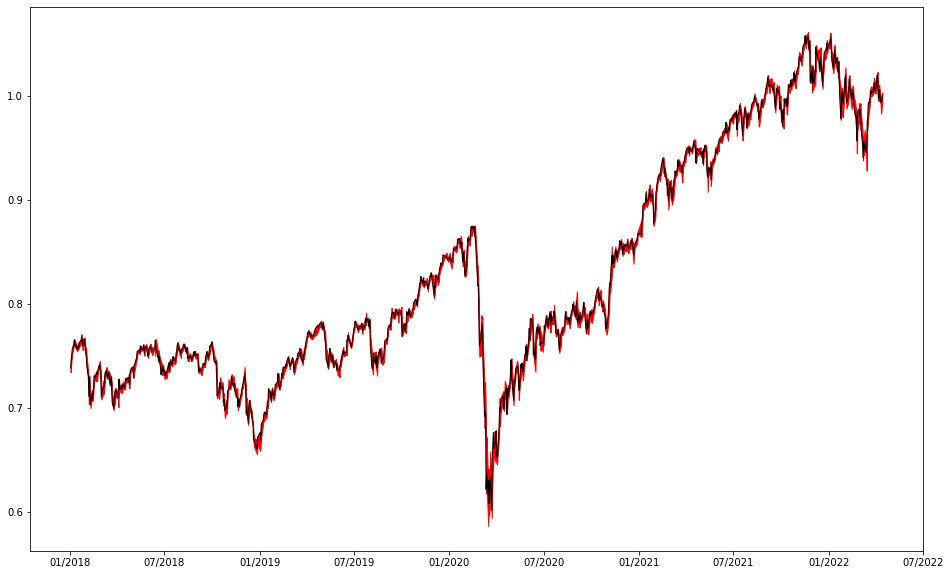

In [145]:
# Plot prices

# TODO: Add vertical lines for % value change 6m / 1y / 5y ago.

# import matplotlib.text as mtext
import matplotlib.dates as mdates

df_plot = df_pf_value.copy()

# Convert to datetime
df_plot['Date'] = pd.to_datetime(df_plot['Date'])

# select starting point
df_plot = df_plot.loc[df_plot.Date >= '2018-01-01']

# Create plot
fig, ax = plt.subplots(figsize=(16, 10))

plt.plot(df_plot.Date, df_plot.Close, color="black", lw=1) 
plt.fill_between(df_plot.Date, df_plot.Low, df_plot.High, color="red") 

# # Add vertical line at reference point for normalized values
# plt.axvline(x=pd.to_datetime(min_date), color='gray', ls='--')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))

plt.savefig('graphics/dashboard_portfolio_value_over_time.png')

## Diversification

Double-Doughnut plot of diversification


Ref: https://stackoverflow.com/questions/44153457/double-donut-chart-in-matplotlib

In [33]:
# Collect all holding information for the portfolio

date_holdings = "2022_03_04"

file_list = ["{dir}/{date}/{file}.tsv".format(**{'dir': 'data/position_trans', 'date': date_holdings, 'file': isin}) for isin in df_pf.Security_ISIN]

positions = pd.DataFrame(columns = ['ISIN_FUND', 'ISIN', 'NAME', 'WEIGHT', 'TICKER', 'SECTOR', 'EXCHANGE', 'COUNTRY'])

for key in file_list:

    data = s3.readFile(AWS_BUCKET, key, sep = "\t")  

    # Subset columns
    cols = ['ISIN_FUND', 'ISIN', 'NAME', 'WEIGHT', 'TICKER', 'SECTOR', 'EXCHANGE', 'COUNTRY']
    data = data[[i for i in cols if i in data.columns]]

    # Append 
    positions = positions.append(data)

# Store in data format readable by both Python and R
positions = positions.reset_index().drop(['index'], axis = 1)

positions.head()

,ISIN_FUND,ISIN,NAME,WEIGHT,TICKER,SECTOR,EXCHANGE,COUNTRY
0,IE00B4L5Y983,US0378331005,APPLE INC,4.77,AAPL,IT,NASDAQ,Vereinigte Staaten
1,IE00B4L5Y983,US5949181045,MICROSOFT CORP,3.74,MSFT,IT,NASDAQ,Vereinigte Staaten
2,IE00B4L5Y983,US0231351067,AMAZON COM INC,2.42,AMZN,Zyklische Konsumgüter,NASDAQ,Vereinigte Staaten
3,IE00B4L5Y983,US02079K3059,ALPHABET INC CLASS A,1.41,GOOGL,Kommunikation,NASDAQ,Vereinigte Staaten
4,IE00B4L5Y983,US02079K1079,ALPHABET INC CLASS C,1.34,GOOG,Kommunikation,NASDAQ,Vereinigte Staaten


In [177]:
# Store positions on disk to work offline
positions.to_csv('positions.tsv', sep='\t')

In [548]:
# Detect positions for which mapping data is missing in equity_info
positions[~positions.ISIN.isin(equity_info.Security_ISIN)].sort_values('WEIGHT', ascending=False)

,ISIN_FUND,ISIN,NAME,WEIGHT,TICKER,SECTOR,EXCHANGE,COUNTRY
5283,IE00B53L3W79,NaN,LINDE PLC,4.57,LIN,Materialien,Xetra,Vereinigte Staaten
2097,IE00BKM4GZ66,NaN,SAMSUNG ELECTRONICS LTD,3.31,005930,IT,Korea Exchange (Stock Market),Korea
5297,IE00B53L3W79,NaN,MERCEDES-BENZ GROUP N AG,1.85,MBG,Zyklische Konsumgüter,Xetra,Deutschland
5343,IE00B4L5YX21,NaN,JPY CASH,1.47,JPY,Cash und/oder Derivate,-,Japan
2102,IE00BKM4GZ66,NaN,JD.COM CLASS A INC,0.86,9618,Zyklische Konsumgüter,Hong Kong Exchanges And Clearing Ltd,China
...,...,...,...,...,...,...,...,...
1579,IE00B4L5Y983,NaN,NaN,NaN,,NaN,NaN,NaN
2094,IE00B5BMR087,NaN,NaN,NaN,,NaN,NaN,NaN
5280,IE00BKM4GZ66,NaN,NaN,NaN,,NaN,NaN,NaN
5337,IE00B53L3W79,NaN,NaN,NaN,,NaN,NaN,NaN


In [329]:
df_pf_region = (
    positions
    # REname columns
    .rename(columns={'ISIN': 'Security_ISIN'})
    # Add Portfolio weights
    .join(df_pf[['Security_ISIN', 'Weight']].rename(columns={'Security_ISIN':'ISIN_FUND'}).set_index('ISIN_FUND'), on='ISIN_FUND')
    # Apply Portfolio weights
    .assign(WEIGHT = lambda x: x.WEIGHT * x.Weight)
    # Aggregate by security
    .groupby(['Security_ISIN']).agg({'WEIGHT':'sum'})
    # Add country information
    .join(equity_info[['Security_ISIN', 'ISO3']].set_index('Security_ISIN'), on='Security_ISIN')
    # Aggregate by country
    .groupby('ISO3').agg({'WEIGHT':'sum'})
    # Add region information
    .join(map_iso3.set_index('ISO3'), on='ISO3')
    # Sort values by WEIGHT
    .sort_values('WEIGHT', ascending=False)
    # reset index so that ISO3 is a column again
    .reset_index()
)
df_pf_region.head()

,ISO3,WEIGHT,region_name,region_sub_name,country_name
0,USA,33.568,Americas,Northern America,United States of America
1,JPN,18.582,Asia,Eastern Asia,Japan
2,FRA,8.268,Europe,Western Europe,France
3,DEU,5.356,Europe,Western Europe,Germany
4,CHN,4.562,Asia,Eastern Asia,China


In [ ]:
# TODO: List of securities with missing country information and relevant exposure (> 0.5% Weight). i.e. missing in mapping!

In [330]:
# Assign residual of WEIGHT to Unknown category
df_pf_unknown = pd.DataFrame.from_dict({
    'ISO3': ['Unknown'],
    'WEIGHT': [100 - df_pf_region.WEIGHT.sum()],
    'region_name': 'Unknown',
    'region_sub_name': 'Unkown',
    'country_name': 'Unknown'

})

df_pf_region = df_pf_region.append(df_pf_unknown)

In [435]:
# RGBA with max 1 -> x/256
# https://colordesigner.io/gradient-generator


from matplotlib.colors import LinearSegmentedColormap

col_region_dict = {
    'Europe': [47, 117, 181, 255],
    'Africa': [153, 0, 255, 255],
    'Americas': [84, 130, 53, 255],
    'Asia': [255, 102, 0, 255],
    'Oceania': [0, 0, 35, 255],
    'Other': [255, 255, 255, 255],
    'Unknown': [165,165,165,255]
}

# Calculate gradient with 10 steps for each color to white

def calc_color_gradient(color, n = 10):
    colors = [color, [255, 255, 255, 255]]

    cm = LinearSegmentedColormap.from_list('', np.array(colors) / 255, 256)
    # TODO: truncate colors to 5 (?) decimal places
    colors_gradient = (cm(np.linspace(0, 1, n)))
    return colors_gradient.tolist()

col_region_dict = {r:calc_color_gradient(c, 6) for r,c in col_region_dict.items()}

# Transform to Dataframe to join
col_region_df = pd.DataFrame.from_dict(col_region_dict)
col_region_df = pd.melt(col_region_df)
col_region_df.columns = ['region_name', 'color']

# Add rank
col_region_df['Rank'] = col_region_df.groupby(['region_name']).cumcount()

col_region_df.head(10)

,region_name,color,Rank
0,Europe,"[0.1843137254901961, 0.4588235294117647, 0.709...",0
1,Europe,"[0.3474509803921569, 0.5670588235294117, 0.767...",1
2,Europe,"[0.5105882352941177, 0.6752941176470588, 0.825...",2
3,Europe,"[0.6737254901960784, 0.7835294117647059, 0.883...",3
4,Europe,"[0.8368627450980393, 0.891764705882353, 0.9419...",4
5,Europe,"[1.0, 1.0, 1.0, 1.0]",5
6,Africa,"[0.6, 0.0, 1.0, 1.0]",0
7,Africa,"[0.6799999999999999, 0.2, 1.0, 1.0]",1
8,Africa,"[0.76, 0.4, 1.0, 1.0]",2
9,Africa,"[0.84, 0.6, 1.0, 1.0]",3


In [436]:
df_plt_region = df_pf_region.groupby(['region_name']).agg({'WEIGHT':'sum'}).reset_index()
# Do not display region with less than 5% of exposure
df_plt_region.loc[(df_plt_region.WEIGHT < 5) & (df_plt_region.region_name!='Unknwon'),'region_name'] = 'Other'
# Aggregate to new categories
df_plt_region = df_plt_region.groupby(['region_name']).agg({'WEIGHT':'sum'}).reset_index()
# Add Rank column for color matching
df_plt_region['Rank'] = 0
# Add colors
df_plt_region = df_plt_region.join(col_region_df.set_index(['region_name', 'Rank']), on=['region_name', 'Rank'])

df_plt_region

,region_name,WEIGHT,Rank,color
0,Americas,34.746,0,"[0.32941176470588235, 0.5098039215686274, 0.20..."
1,Asia,29.690,0,"[1.0, 0.4, 0.0, 1.0]"
2,Europe,22.544,0,"[0.1843137254901961, 0.4588235294117647, 0.709..."
3,Other,0.900,0,"[1.0, 1.0, 1.0, 1.0]"
4,Unknown,12.120,0,"[0.6470588235294118, 0.6470588235294118, 0.647..."


In [437]:
# Aggregat by sub region
df_plt_region_sub = df_pf_region.groupby(['region_name', 'region_sub_name']).agg({'WEIGHT':'sum'}).reset_index()

# Assign other category as done on region level
df_plt_region_sub.loc[~df_plt_region_sub.region_name.isin(df_plt_region.region_name), ['region_name', 'region_sub_name']] = 'Other'

# For each sub region, assign Other where WEIGHT < 5%
df_plt_region_sub.loc[(df_plt_region_sub.WEIGHT < 5) & (df_plt_region_sub.region_sub_name!='Unknwon'),'region_sub_name'] = 'Other'

# TODO: keep only top 5

df_plt_region_sub = df_plt_region_sub.groupby(['region_name', 'region_sub_name']).agg({'WEIGHT':'sum'}).reset_index()

# Sort values by group to match colors
df_plt_region_sub = df_plt_region_sub.groupby(['region_name']).apply(lambda x: x.sort_values(['WEIGHT'], ascending=False)).reset_index(drop=True)

df_plt_region_sub['Rank'] = df_plt_region_sub.groupby(['region_name']).cumcount()

# Add colors
df_plt_region_sub = df_plt_region_sub.join(col_region_df.set_index(['region_name', 'Rank']), on=['region_name', 'Rank'])

df_plt_region_sub

,region_name,region_sub_name,WEIGHT,Rank,color
0,Americas,Northern America,34.236,0,"[0.32941176470588235, 0.5098039215686274, 0.20..."
1,Americas,Other,0.510,1,"[0.46352941176470586, 0.6078431372549019, 0.36..."
2,Asia,Eastern Asia,25.984,0,"[1.0, 0.4, 0.0, 1.0]"
3,Asia,Other,3.706,1,"[1.0, 0.52, 0.2, 1.0]"
4,Europe,Western Europe,17.786,0,"[0.1843137254901961, 0.4588235294117647, 0.709..."
5,Europe,Other,4.758,1,"[0.3474509803921569, 0.5670588235294117, 0.767..."
6,Other,Other,0.900,0,"[1.0, 1.0, 1.0, 1.0]"
7,Unknown,Unkown,12.120,0,"[0.6470588235294118, 0.6470588235294118, 0.647..."


In [443]:
# Aggregate by ISO3
df_plt_country = df_pf_region.groupby(['region_name', 'region_sub_name', 'ISO3']).agg({'WEIGHT':'sum'}).reset_index()

# Assign other where region + region_sub are other
idx_region = ~df_plt_country.region_name.isin(df_plt_region_sub.region_name)
idx_region_sub = ~df_plt_country.region_sub_name.isin(df_plt_region_sub.region_sub_name)

df_plt_country.loc[idx_region, ['region_name', 'ISO3']] = 'Other'
df_plt_country.loc[idx_region_sub, ['region_sub_name', 'ISO3']] = 'Other'

idx_too_small = (df_plt_country.WEIGHT < 2.5) & (df_plt_country.region_sub_name!='Unknwon')
df_plt_country.loc[idx_too_small, ['ISO3']] = 'Other'

df_plt_country = df_plt_country.groupby(['region_name', 'region_sub_name', 'ISO3']).agg({'WEIGHT':'sum'}).reset_index()

# Add weights by REGION + Sub_region to make sure all 3 tables are sorted the same way
df_plt_country = df_plt_country.join(
    df_plt_region_sub[['region_name', 'region_sub_name', 'WEIGHT', 'Rank']]
    .rename(columns={'WEIGHT': 'WEIGHT_region_sub', 'Rank': 'Rank_region_sub'}).set_index(['region_name', 'region_sub_name']), on=['region_name', 'region_sub_name'])

# Sort values by group to match colors
df_plt_country = df_plt_country.groupby(['region_name']).apply(lambda x: x.sort_values(['WEIGHT_region_sub', 'WEIGHT'], ascending=[False, False])).reset_index(drop=True)

df_plt_country['Rank'] = df_plt_country.groupby(['region_name', 'region_sub_name']).cumcount()
# Add rank from region_sub to match colors
df_plt_country['Rank'] = df_plt_country['Rank'] + df_plt_country['Rank_region_sub']

# Add colors
df_plt_country = df_plt_country.join(col_region_df.set_index(['region_name', 'Rank']), on=['region_name', 'Rank'])

df_plt_country.head(20)

,region_name,region_sub_name,ISO3,WEIGHT,WEIGHT_region_sub,Rank_region_sub,Rank,color
0,Americas,Northern America,USA,33.568,34.236,0,0,"[0.32941176470588235, 0.5098039215686274, 0.20..."
1,Americas,Northern America,Other,0.668,34.236,0,1,"[0.46352941176470586, 0.6078431372549019, 0.36..."
2,Americas,Other,Other,0.510,0.510,1,1,"[0.46352941176470586, 0.6078431372549019, 0.36..."
3,Asia,Eastern Asia,JPN,18.582,25.984,0,0,"[1.0, 0.4, 0.0, 1.0]"
4,Asia,Eastern Asia,CHN,4.562,25.984,0,1,"[1.0, 0.52, 0.2, 1.0]"
5,Asia,Eastern Asia,TWN,2.584,25.984,0,2,"[1.0, 0.64, 0.4, 1.0]"
6,Asia,Eastern Asia,Other,0.256,25.984,0,3,"[1.0, 0.76, 0.6, 1.0]"
7,Asia,Other,Other,3.706,3.706,1,1,"[1.0, 0.52, 0.2, 1.0]"
8,Europe,Western Europe,FRA,8.268,17.786,0,0,"[0.1843137254901961, 0.4588235294117647, 0.709..."
9,Europe,Western Europe,DEU,5.356,17.786,0,1,"[0.3474509803921569, 0.5670588235294117, 0.767..."


In [444]:
# Check weights 
(
    df_plt_region.WEIGHT.sum(),
    df_plt_region_sub.WEIGHT.sum(),
    df_plt_country.WEIGHT.sum()
)

(100.0, 99.99999999999999, 99.99999999999997)

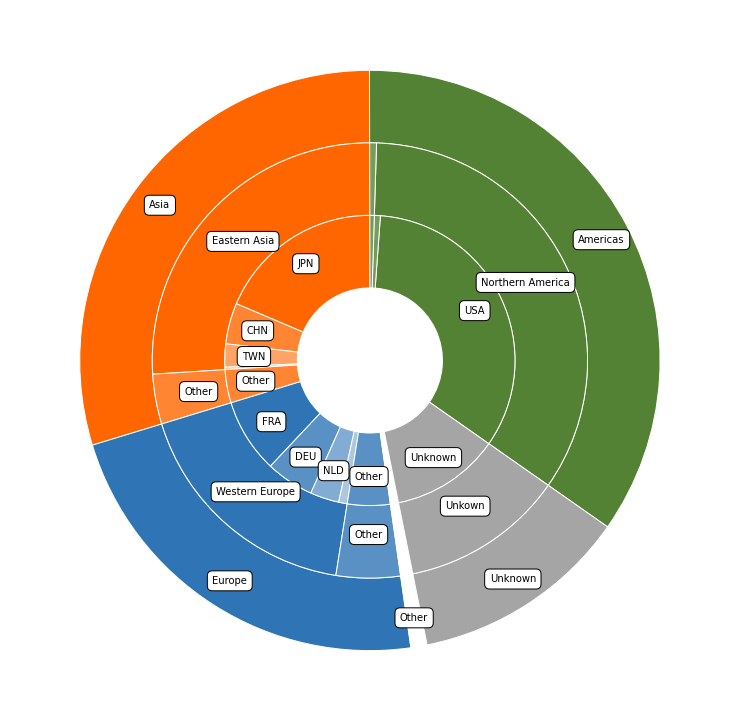

In [546]:
# Matplotlib text properties: https://matplotlib.org/stable/tutorials/text/text_props.html

# TODO: linebreak labels at each space !?
# TODO: Add % to most text boxes!

fig, ax = plt.subplots(figsize=(13,13))
ax.axis('equal')
# Width of each doghnut
width = 0.25

# Adjust all labels
lab_region = df_plt_region.region_name # Always display all labels for region, to show the "Other" category
lab_region_sub = [l if w > 1 else "" for l, w in zip(df_plt_region_sub.region_sub_name, df_plt_region_sub.WEIGHT)]
lab_country = [l if w > 1 else "" for l, w in zip(df_plt_country.ISO3, df_plt_country.WEIGHT)]

# Region
pie_region, _ = ax.pie(
    list(df_plt_region.WEIGHT), 
    radius=1, 
    labels=lab_region, 
    colors=df_plt_region.color, 
    labeldistance=.9, 
    startangle = -35,
    # rotatelabels=True, 
    # Make transparent, round edges, bordercolor=black? etc.
    textprops={
        'ha':'center', 'va':'center',
        'bbox': dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5)})

# Subregion
pie_region_sub, _ = ax.pie(
    list(df_plt_region_sub.WEIGHT), 
    radius=1-width, 
    labels=lab_region_sub, 
    colors=df_plt_region_sub.color, 
    labeldistance=0.8, 
    startangle = -35,
    # rotatelabels=True,
    textprops={
        'ha':'center',
        'bbox': dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5)})

# Country / ISO3
pie_country, _ = ax.pie(
    list(df_plt_country.WEIGHT),
    radius=1-2*width, 
    labels=lab_country, 
    colors=df_plt_country.color, 
    labeldistance=0.8, 
    startangle = -35,
    # rotatelabels=True,
    textprops={
        'ha':'center',
        'bbox': dict(facecolor='white', edgecolor='black', boxstyle='round', pad=.5)})

# General setup
plt.setp(pie_region, width=width, edgecolor='white')
plt.setp(pie_region_sub, width=width, edgecolor='white')
plt.setp(pie_country, width=width, edgecolor='white')

# plt.show()

plt.savefig('graphics/dashboard_diversification_doughnut.png')